<a href="https://colab.research.google.com/github/siddhamapple/Projects/blob/main/MindMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
!pip install networkx
!pip install rake-nltk
!pip install sentence-transformers networkx rake-nltk matplotlib

import nltk
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from rake_nltk import Rake
from keybert import KeyBERT


%matplotlib inline




In [222]:
 nltk.download('stopwords')
 nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [223]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [224]:
filepath='/content/drive/MyDrive/Mind_map_project/summary.txt'

In [225]:
with open(filepath,"r") as f:
  summary=f.read()

In [226]:
# text="""Artificial Intelligence (AI) is transforming industries by automating tasks and generating insights from data. Machine Learning (ML), a subset of AI, enables systems to learn from data and improve over time without explicit programming. Deep Learning (DL) uses neural networks to solve complex problems like image recognition and natural language processing. AI applications include autonomous vehicles, personalized recommendations, fraud detection, and predictive maintenance. However, AI also raises ethical concerns, such as bias, privacy, and job displacement. Organizations must balance innovation with responsible AI practices to ensure fairness and transparency.
# """

In [227]:
sentences = nltk.sent_tokenize(summary)


In [228]:
# !pip install keybert
# from keybert import KeyBERT

# kw_model = KeyBERT(model=SentenceTransformer('all-MiniLM-L6-v2'))
# keywords = kw_model.extract_keywords(summary, keyphrase_ngram_range=(1, 3), stop_words='english', top_n=top_N)
# keywords = [kw[0] for kw in keywords]
# print("Extracted Keywords:", keywords)

In [229]:
r = Rake(max_length=3)
r.extract_keywords_from_text(summary)
candidate_phrases = [phrase for score, phrase in r.get_ranked_phrases_with_scores()]
print("Candidate Keywords:", candidate_phrases)

#  Filter using TF-IDF importance
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(candidate_phrases)
tfidf_scores = np.asarray(X.sum(axis=1)).flatten()
sorted_indices = np.argsort(-tfidf_scores)  # descending order

top_N = 5
top_keywords = [candidate_phrases[idx] for idx in sorted_indices[:top_N]]
print("Selected Keywords after TF-IDF Filtering:", top_keywords)


keywords = top_keywords

Candidate Keywords: ['reduce fuel costs', 'iot systems function', 'fuel efficiency', 'smart buildings', 'sensors embedded', 'iot gateway', 'iot devices', 'improves communication', 'improve sustainability', 'end system', 'connected cars', 'computer interactions', 'gathering data', 'iot', 'data', 'transmitted', 'transferable', 'monitored', 'human', 'human', 'example', 'construction', 'cities', 'back', 'application', 'analysis']
Selected Keywords after TF-IDF Filtering: ['reduce fuel costs', 'iot systems function', 'smart buildings', 'sensors embedded', 'improves communication']


In [230]:
# vectorizer = TfidfVectorizer(stop_words='english') #gives each word tf idf score
# X = vectorizer.fit_transform(keywords) #X is a matrix of shape = (number of sentences, number of keywords)

In [231]:
model = SentenceTransformer('all-MiniLM-L6-v2')
keyword_embeddings = model.encode(keywords)
similarity_matrix = cosine_similarity(keyword_embeddings)


In [244]:
flat_sim = similarity_matrix.flatten()
non_zero_flat_sim = flat_sim[flat_sim > 0]
threshold = np.percentile(non_zero_flat_sim, 30) if len(non_zero_flat_sim) > 0 else 0.01
print(f"Threshold chosen: {threshold:.2f}")

Threshold chosen: 0.12


In [245]:
G = nx.DiGraph()
for keyword in keywords:
    G.add_node(keyword)
    print(keyword)

reduce fuel costs
iot systems function
smart buildings
sensors embedded
improves communication


In [246]:
for i, keyword_i in enumerate(keywords):
    for j, keyword_j in enumerate(keywords):
        if i != j and similarity_matrix[i][j] >= threshold:
            G.add_edge(keyword_i, keyword_j, weight=similarity_matrix[i][j])


In [247]:
degree_dict = dict(G.degree())
central_node = max(degree_dict, key=degree_dict.get)
print("Auto-detected Central Keyword:", central_node)

pos = nx.spring_layout(G, center=(0, 0))

pos[central_node] = np.array([0.0, 0.0])


for node in pos:
    if node != central_node:
        pos[node] = pos[node] * 1.5

Auto-detected Central Keyword: iot systems function


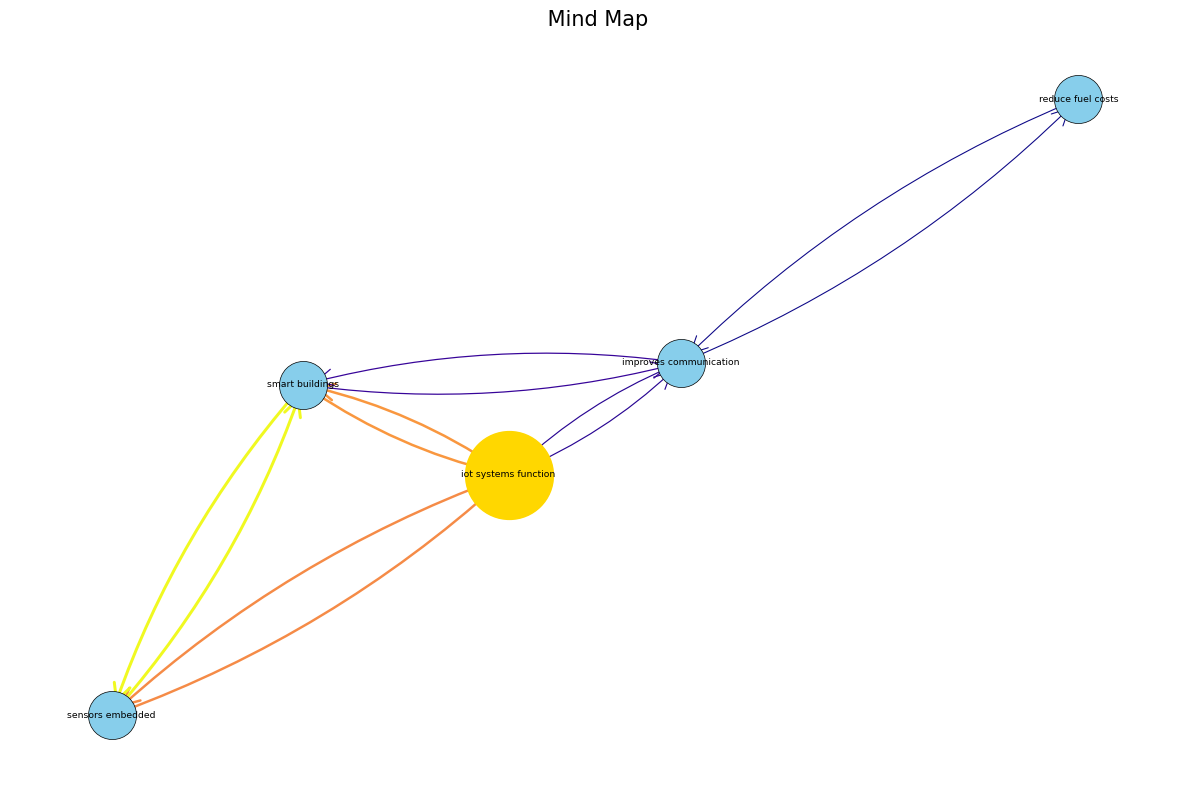

In [248]:
plt.figure(figsize=(12,8))

weights = np.array([d['weight'] for u, v, d in G.edges(data=True)]) # u source  v destination d dictionary of weights
if len(weights) > 0:
    norm = plt.Normalize(weights.min(), weights.max())
    colors = cm.plasma(norm(weights))
else:
    colors = 'gray'

# Drawinf nodes
nx.draw_networkx_nodes(G, pos, node_size=1200, node_color='skyblue',edgecolors='black', linewidths=0.5)

nx.draw_networkx_nodes(G, pos, nodelist=[central_node], node_size=4000, node_color='gold')

# Draw edges with arrows, variable width and color
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='->',
    arrowsize=30,
    edge_color=colors,
    width=weights * 5 if len(weights) > 0 else 1,   # thickness proportional to weight
    connectionstyle='arc3,rad=0.1'  # slight curve to avoid overlaps
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=6.7)



plt.title(" Mind Map", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

In [249]:
# Candidate phrases → rake_nltk

# Importance filtering → tf-idf

# Similarity → sentence-transformers

# Graph → networkx

# Visual → matplotlib